In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import tensorflow as tf

In [7]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


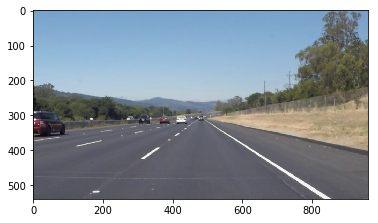

In [8]:
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [9]:
def grayscale(img):
    """Applies the Grayscale transform
    to the image"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Keeps only the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #Define a blank mask made up of zeros 
    mask = np.zeros_like(img)   
    
    #Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #Return the image only where mask pixels are non-zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """  
    Separates line segments by their slope ((y2-y1)/(x2-x1)) ,
    creating 2 groups: if a line has a positive slope value
    it will be appended to group 1; if the slope has a negative value
    it will end up in group 2.
    Horizontal or vertical lines are ignored (that is, if the 
    denominator or dividend is equal to 0, the line will not be saved).
    
    A final left line is calculated by averaging the position of each
    of the segments that belong to group 1. The process is repeated 
    for a final right line, using group 2. These two lines are then
    extrapolated to the top and bottom of the lane. 
    
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def refined_draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    rm = []
    lm = []
    rc = []
    lc = []
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (((x2-x1)==0) or ((y2-y1)==0)):
                None
            else:
                slope = (y2-y1)/(x2-x1)
                center = [(x2+x1)/2,(y2+y1)/2]
                if (slope > 0.5): 
                    rm.append(slope)
                    rc.append(center)
                elif (slope < (-0.5)):
                    lm.append(slope)
                    lc.append(center)
                else:
                    None
    
    r_slope = np.sum(rm)/len(rm)
    l_slope = np.sum(lm)/len(lm)
    
    r_center = np.divide(np.sum(rc,axis=0),len(rc))
    l_center = np.divide(np.sum(lc,axis=0),len(lc))
    
#     #Draw right line        
    x1= int((-r_center[1]+540+(r_slope)*(r_center[0]))/r_slope)
    y1=540
    x2= int((330-r_center[1]+(r_slope)*(r_center[0]))/r_slope)
    y2=330
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
#     #Draw left line       
    x1= int((-l_center[1]+540+(l_slope)*(l_center[0]))/l_slope)
    y1=540
    x2= int((330-l_center[1]+(l_slope)*(l_center[0]))/l_slope)
    y2=330
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def refined_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    refined_draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def process_image(image):
    color_select = np.copy(image)
    gray = grayscale(color_select)
    canny_img = canny(gray, 100, 150)
    gauss_img = gaussian_blur(canny_img, 7)
    imshape = gray.shape
    vertices= np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    interest=region_of_interest(gauss_img,vertices)
    hough = hough_lines(interest, 2, np.pi/180, 100, 20, 100)
    weighted = weighted_img(hough, color_select, α=0.8, β=1., γ=0.)
    return weighted

def refined_process_image(image):
    
    color_select = np.copy(image)
    gray = grayscale(color_select)
    canny_img = canny(gray, 100, 150)
    gauss_img = gaussian_blur(canny_img, 7)
    imshape = gray.shape
    vertices= np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    interest=region_of_interest(gauss_img,vertices)
    hough = refined_hough_lines(interest, 2, np.pi/180, 100, 20, 100)
    weighted = weighted_img(hough, color_select, α=0.8, β=1., γ=0.)
    return weighted


True

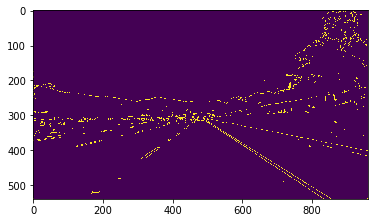

In [17]:

color_select = np.copy(image)
gray = grayscale(color_select)
canny_img = canny(gray, 100, 150)
plt.imshow(canny_img)
cv2.imwrite("canny_img.png", canny_img)


In [ ]:
color_select = np.copy(image)
gray = grayscale(color_select)
canny_img = canny(gray, 100, 150)
plt.imshow(canny_img)
cv2.imwrite("canny_img.png", canny_img)

True

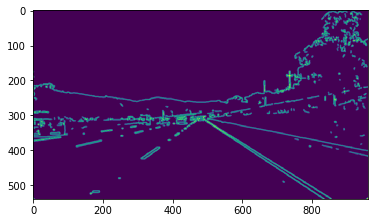

In [20]:
gauss_img = gaussian_blur(canny_img, 7)
plt.imshow(gauss_img)
cv2.imwrite("gauss_img.png", gauss_img)

True

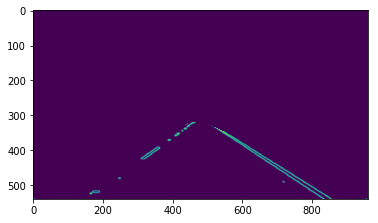

In [22]:
imshape = gray.shape
vertices= np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
interest=region_of_interest(gauss_img,vertices)
plt.imshow(interest)
cv2.imwrite("interest.png", interest)

True

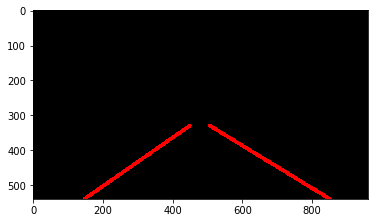

In [23]:
hough = refined_hough_lines(interest, 2, np.pi/180, 100, 20, 100)
plt.imshow(hough)
cv2.imwrite("hough.png", hough)

True

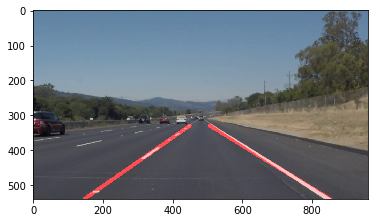

In [24]:
weighted = weighted_img(hough, color_select, α=0.8, β=1., γ=0.)
plt.imshow(weighted)
cv2.imwrite("weighted.png", weighted)